# Optimizers

In this notebook we will be comparing the most common optimizer to train feed-forward neural networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

$$
    f(x, y) = x^2 + 2xy + y^2
$$

$$
    \nabla f = \begin{bmatrix} 2x + 2y \\ 2y + 2x\end{bmatrix}
$$

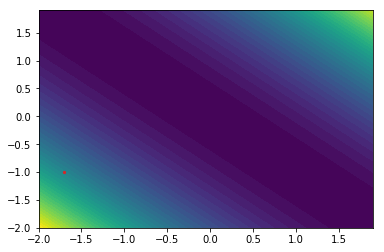

In [20]:
def f(x, y): return x ** 2 + 2 * x * y + y ** 2

X, Y = np.mgrid[-2: 2:0.1, -2: 2:0.1]

plt.contourf(X, Y, f(X, Y), 50)
plt.scatter(-1.7, -1,5, c="tab:red")

In [78]:
def gradf(f, *xv, epsilon=1e-6):
    """
    Approximate the numerical gradient of f
    """
    nx = len(xv)
    xv_stack = np.array([xv for _ in range(nx)]).reshape(-1, nx)
    xv_stack_pos = (xv_stack + np.eye(nx) * epsilon).T
    xv_stack_neg = (xv_stack - np.eye(nx) * epsilon).T
    grad = (f(*xv_stack_pos) - f(*xv_stack_neg)) / (2 * epsilon)
    return grad

In [79]:
gradf(f, 1, 2)

array([ 6.,  6.])

In [67]:
f(*gradf(f, 1, 2).T)

array([ 9.000006,  9.000006])

In [54]:
xv = (1, 2, 3)
epsilon = 1e-6
np.array([xv for i in range(len(xv))]).reshape(-1, 3) + np.eye(3) * epsilon

array([[ 1.000001,  2.      ,  3.      ],
       [ 1.      ,  2.000001,  3.      ],
       [ 1.      ,  2.      ,  3.000001]])